### 10-2. CAM, Grad-CAM용 모델 준비하기 (1) 데이터셋 준비하기

CAM(Class Activation Map)은 특성을 추출하는 CNN 네트워크 뒤에 GAP(Global Average Pooling)와 소프트맥스 레이어(softmax layer)가 붙는 형태로 구성되어야 한다는 제약이 있습니다. 반면에 Grad-CAM은 이러한 제약이 없죠.

우리는 이번 시간에 두 가지를 모두 구현해 보겠습니다.
우선 CAM을 위한 모델을 먼저 구성해 기본적인 CAM을 추출해보고, 이 모델에서 Grad-CAM을 활용해 다시 시각화 결과물을 추출하겠습니다. Grad-CAM은 모델의 구조에 제약이 없기 때문에 CAM에만 모델을 맞춰도 충분하기 때문입니다.

CAM은 클래스에 대한 활성화 정도를 나타낸 지도입니다. 따라서 기본적으로 우리의 모델은 분류(classfication)를 수행하는 모델이어야 합니다. 하지만 우리의 최종 목표는 이미지 내에서 클래스가 활성화 된 위치를 확인하고 이를 정답과 비교하는 것이므로 위치 정보가 기록된 데이터가 함께 있어야 합니다.

Tensorflow Datasets의 카탈로그에서 이러한 데이터를 확인할 수 있는데요. 여기서는 Cars196 데이터셋을 사용하겠습니다. 이는 196종의 자동차 종류를 사진으로 판별하는 분류 문제 데이터셋으로, 라벨이 위치정보인 바운딩 박스(bounding box) 정보를 포함하고 있습니다. 그럼 필요한 라이브러리와 데이터셋을 준비하고 시작하겠습니다.

In [3]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

cars196 데이터셋은 8,144장의 학습용 데이터셋과 8,041장의 평가용 데이터셋으로 구성되어있습니다. tfds.load()를 활용해서 데이터셋을 다운로드 해주세요.

In [5]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

tfds.show_examples() 를 통해서 각 이미지의 클래스와 그 인덱스(index)를 확인할 수 있습니다.

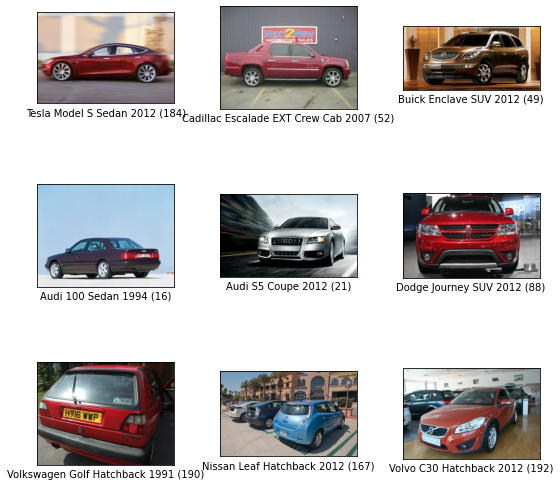

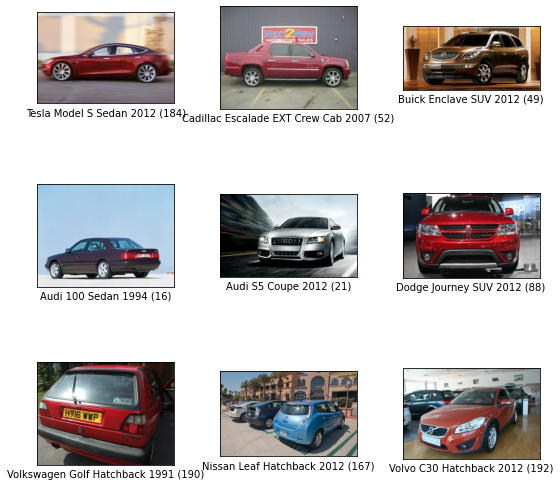

In [6]:
tfds.show_examples(ds_train, ds_info)

학습용 데이터셋 뿐만 아니라 평가용 데이터셋도 눈으로 확인해 보세요.

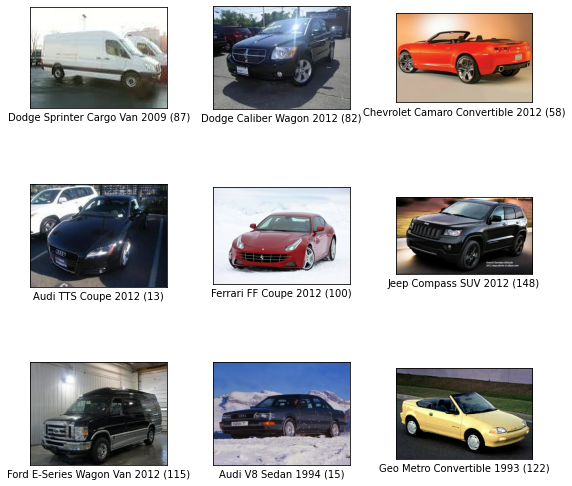

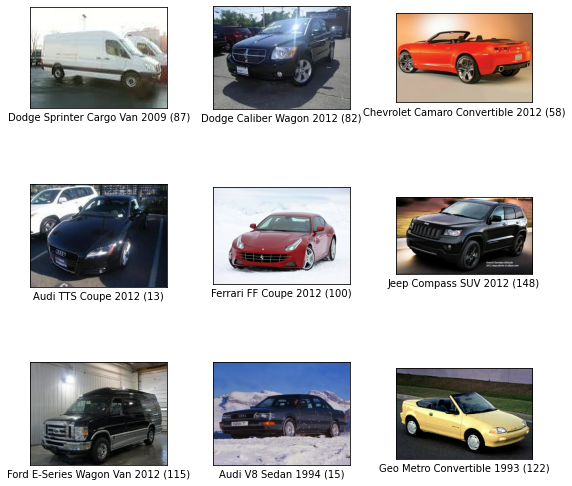

In [7]:
tfds.show_examples(ds_test, ds_info)

## 10-3. CAM, Grad-CAM용 모델 준비하기 (2) 물체의 위치정보

In [8]:
ds_info.features

FeaturesDict({
    'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
})

## 10-4. CAM, Grad-CAM용 모델 준비하기 (3) CAM을 위한 모델 만들기


### 이번에는 본격적으로 CAM을 얻어내기 위한 모델을 만들어 보겠습니다. 이번에는 미리 이미지넷(imagenet) 데이터에 훈련된 resnet50을 기반으로 활용하고, 이후 pooling layer 뒤에 소프트맥스 레이어를 붙여 Grad-CAM 모델을 만들겠습니다.

참고로, 소프트맥스 레이어는 소프트맥스 함수를 활성화 함수로 사용하는 fully connected 레이어입니다.



아래에서 직접 resnet50 뒤에 필요한 레이어를 붙여 CAM을 구하기 위한 기본 모델을 완성해 주세요. CAM 모델의 구조가 생각나지 않는다면, Lecture 노드나 관련 내용을 참고해 완성해 보세요.

In [ ]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',
)
x = base_model.output
# preds = ADD_YOUR_LAYER(x)

preds = keras.layers.Dense(num_classes, activation = 'softmax')(x)

cam_model=keras.Model(inputs=base_model.input, outputs=preds)

In [1]:
# 아래에서 직접 만든 CAM모델을 확인해 주세요.
cam_model.summary()


NameError: name 'cam_model' is not defined

## 10-5. CAM, Grad-CAM용 모델 준비하기 (4) CAM 모델 학습하기

이제 학습을 위한 과정은 이전과 비슷합니다.

input에 이전과 다르게 bbox 정보가 포함되어있지만, 지금 수행해야 할 CAM 모델의 학습에는 필요가 없으므로 normalize_and_resize_img에서 제외해 주었습니다. CAM 모델은 object detection이나 segmentation에도 활용될 수 있지만, bounding box같은 직접적인 라벨을 사용하지 않고 weakly supervised learning을 통해 물체 영역을 간접적으로 학습시키는 방식이기 때문입니다.

In [9]:
def normalize_and_resize_img(input):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

In [11]:
tf.random.set_seed(2020)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [12]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=5,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Train for 509 steps, validate for 502 steps
Epoch 1/5
509/509 [==============================] - 97s 190ms/step - loss: 4.1834 - accuracy: 0.1616 - val_loss: 5.5999 - val_accuracy: 0.0083
Epoch 2/5
509/509 [==============================] - 84s 165ms/step - loss: 1.6600 - accuracy: 0.6365 - val_loss: 2.0147 - val_accuracy: 0.4879
Epoch 3/5
509/509 [==============================] - 94s 185ms/step - loss: 0.5815 - accuracy: 0.8926 - val_loss: 1.2315 - val_accuracy: 0.6774
Epoch 4/5
509/509 [==============================] - 90s 177ms/step - loss: 0.1641 - accuracy: 0.9837 - val_loss: 1.1161 - val_accuracy: 0.7082
Epoch 5/5
509/509 [==============================] - 91s 179ms/step - loss: 0.0578 - accuracy: 0.9973 - val_loss: 1.0404 - val_accuracy: 0.7211


학습시킨 가중치를 저장해 주겠습니다.

In [13]:
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model.save(cam_model_path)

## 10-6. CAM

이제 학습된 모델에서 CAM을 만들어 봅시다. CAM은 데이터셋 전체가 아닌 한 장에 대해 확인을 해야하기 때문에 get_one() 함수로 데이터셋에서 한 장씩 뽑을 수 있도록 했습니다.

In [14]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

120


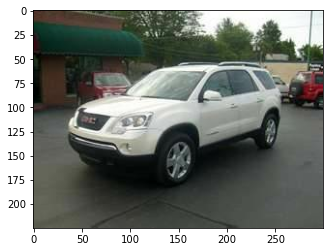

In [15]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

이제 데이터가 준비되었으니 CAM을 만들 모델을 불러와 봅시다.

In [16]:
cam_model = tf.keras.models.load_model(cam_model_path)

CAM을 만들기 위해서는 (1) 특성 맵, (2) 클래스 별 확률을 얻기 위한 소프트맥스 레이어의 가중치, 그리고 (3) 원하는 클래스의 출력값이 필요합니다. 또 이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하려면 네트워크에서 나온 CAM을 입력 이미지 사이즈와 같게 만들어 함께 시각화 해야 할 것입니다. 이를 고려해서 model과 item을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환하는 함수를 만들어야 합니다.

generate_cam() 을 구현하기 위해 아래에서는 conv_ouputs와 같이 특정 레이어의 결과값을 결과로 받기 위해 새로운 모델을 정의하고 feedforward를 거친 후 CAM을 계산하도록 구현하였습니다. 마지막에는 입력 이미지의 크기에 맞춰 CAM을 resize 해주었습니다.

In [17]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

이제 위에서 작성한 함수를 실행하면 아래와 같은 CAM을 얻을 수 있습니다. 생각보다 위치를 정확하게 표현하고 있습니다.

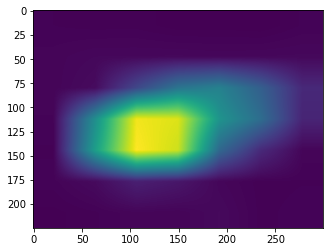

In [18]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

이렇게 그려진 CAM 이미지를 원본 이미지와 합쳐 봅시다.



In [19]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

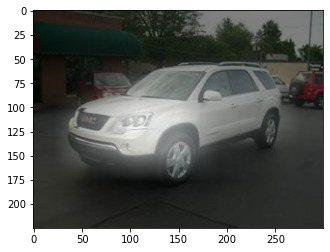

In [20]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

## 10-7. Grad-CAM

이번에는 Grad-CAM을 이용해서 CAM을 얻어보도록 하겠습니다. 적용 모델을 유연하게 선택할 수 있는 Grad-CAM의 특성 상 위에서 만들었던 모델을 다시 활용해도 괜찮기 때문에 관찰 대상 모델은 cam_model을 그대로 활용합시다.
우선 새로운 이미지를 뽑아봅시

12


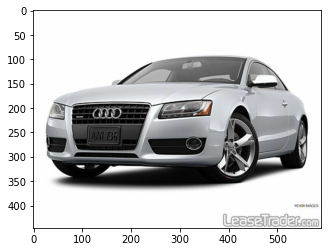

In [21]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

이번에는 Grad-CAM을 이용해서 CAM을 만들어 봅시다.

grad_cam은 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 그래디언트를 구하고, 여기에 GAP 연산을 적용함으로써 관찰 대상이 되는 레이어의 채널별 가중치를 구합니다. 최종 CAM 이미지를 구하기 위해서는 레이어의 채널별 가중치(weights)와 레이어에서 나온 채널별 특성 맵을 가중합 해주어 cam_image를 얻게 됩니다.

위에서 본 CAM 함수와 달리, Grad-CAM은 이번에는 어떤 레이어든 CAM 이미지를 뽑아낼 수 있으므로, 그래디언트 계산을 원하는 관찰 대상 레이어 activation_layer를 뽑아서 쓸 수 있도록 activation_layer의 이름을 받고 이를 활용해야 합니다.

아래 generate_grad_cam()에서는 원하는 레이어의 output과 특정 클래스의 prediction 사이의 그래디언트 grad_val을 얻고 이를 weights로 활용합니다.

In [22]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

이제 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해보세요! 레이어의 이름은 cam_model.summary()에서 찾을 수 있습니다.

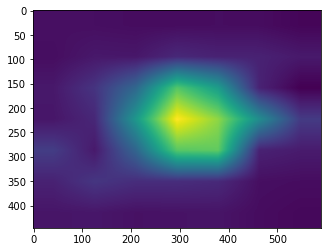

In [23]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

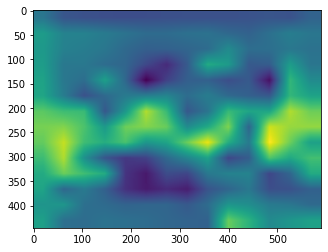

In [24]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)

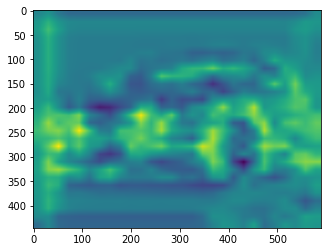

In [25]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)

## 10-8. Detection with CAM

바운딩 박스
마지막으로 이번에는 CAM에서 물체의 위치를 찾는 detection을 해 보도록 하겠습니다.

87


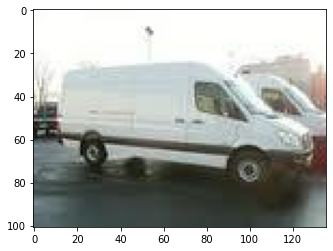

In [26]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

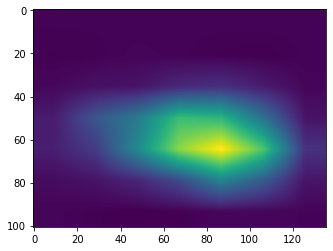

In [27]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

이전의 generate_cam을 활용해서 CAM 이미지를 뽑아봅시다. 아래 get_bbox() 함수는 바운딩 박스를 만들기 위해서 score_thresh를 받아 역치값 이하의 바운딩 박스는 없앱니다. 그 다음 OpenCV의 findContours()와 minAreaRect()로 사각형을 찾습니다. 이때 rotated_rect 라는 회전된 바운딩 박스를 얻을 수 있습니다. boxPoints()로 이를 꼭지점으로 바꾸어 줍니다. 마지막에는 int 자료형으로 변환해 줍니다.

In [28]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [29]:
# 아래에서 bbox를 얻고 이미지로 바운딩 박스를 얻는 모습을 볼 수 있습니다.
image = copy.deepcopy(item['image'])
rect = get_bbox(cam_image)
rect

array([[135,  92],
       [  0,  92],
       [  0,  27],
       [135,  27]])

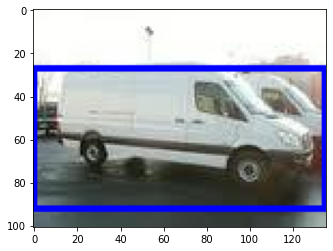

In [30]:
image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)

### Intersection Over Union
위에서 CAM과 Grad-CAM 두 가지 방법을 통해서 얻은 바운딩 박스가 있습니다. 그럼 정답 데이터인 바운딩 박스와 이를 비교 평가 할 때는 어떻게 할 수 있을까요?

IoU(Intersection over Union)는 두 개 영역의 합집합인 "union" 영역으로 교집합 영역인 "intersection" 영역의 넓이를 나누어준 값입니다. 이를 통해 찾고자 하는 물건의 절대적인 면적과 상관없이, 영역을 정확하게 잘 찾아내었는지 상대적인 비율을 구할 수 있으므로 모델이 영역을 잘 찾았는지 비교하는 좋은 지표가 됩니다.

In [41]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [42]:
# 위에서 구했던 rect를 minmax bbox 형태로 치환해 봅시다.
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

# 이 데이터의 ground truth bbox를 확인해 봅시다.
item['bbox']


array([0.35353535, 0.02272727, 0.8888889 , 0.99242425], dtype=float32)

어떤가요? CAM 추론 결과로 얻어진 bbox가 ground truth bbox와 비슷하게 얻어졌나요? 얼마나 유사한지를 IoU를 계산해서 확인해 봅시다.

In [43]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [44]:
get_iou(pred_bbox, item['bbox'])

0.08581017606034376